In [1]:
import os
os.environ["DDE_BACKEND"] = "pytorch"
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde
import torch

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


The one dimensional Burger's equation is,

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}\ $$
Where, 
$$x \in [-1, 1], \;\;\; t \in [0, 1]$$
With Dirichilet boundary conditions and initial condition,
$$u(-1, t) = u(1, t) = 0, \;\;\; u(x, 0) = -\sin(\pi x)$$

In [2]:
plt.close('all')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

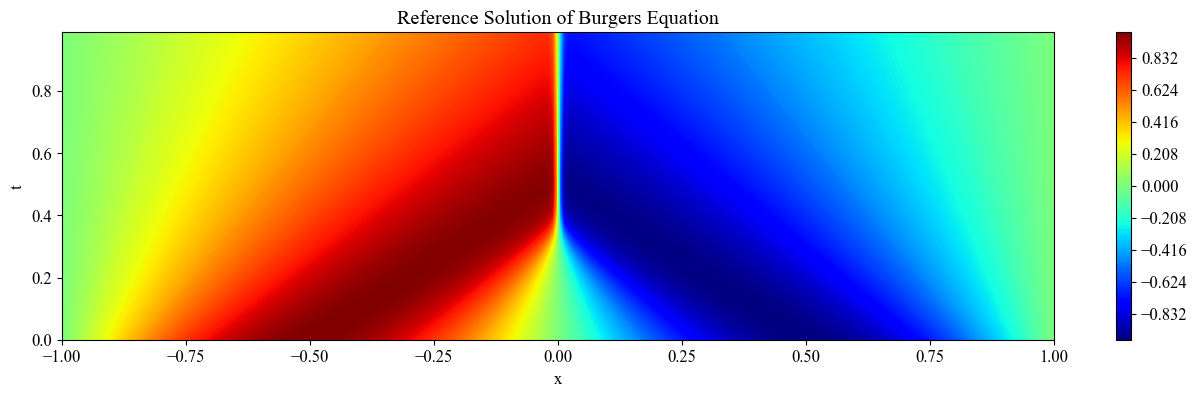

In [3]:
data = np.load("Data/Burgers.npz")
t_ref, x_ref, exact_u = data["t"], data["x"], data["usol"].T
x_ref, t_ref = np.meshgrid(x_ref, t_ref)

X_ref = np.vstack((np.ravel(x_ref), np.ravel(t_ref))).T
Y_ref = exact_u.flatten()[:, None]

plt.figure(figsize=(16, 4))
plt.contourf(x_ref, t_ref, exact_u, levels=250, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title("Reference Solution of Burgers Equation")
plt.show()

In [4]:
def pde(x, y):
    dy_dx = dde.grad.jacobian(y, x, 0, 0)
    dy_dt = dde.grad.jacobian(y, x, 0, 1)
    d2y_dx2 = dde.grad.hessian(y, x, component=0, i=0, j=0)
    return dy_dt + y * dy_dx - 0.01 / np.pi * d2y_dx2

In [5]:
def is_on_boundary (x, on_boundary):

    if not on_boundary:
        return False
    
    return np.isclose(x[0], -1) or np.isclose(x[0], 1)

def boundary_value(x):
    return 0

In [6]:
def is_on_initial_condition(x, on_initial):
    return on_initial and dde.utils.isclose(x[1], 0)

def initial_value(x):
    return -np.sin(np.pi * x[:, 0:1])

In [7]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1.0)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [8]:
bc = dde.icbc.DirichletBC(geomtime, boundary_value, is_on_boundary)
ic = dde.icbc.IC(geomtime, initial_value, is_on_initial_condition)

In [9]:
data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=2540, num_boundary=80, num_initial=160)

In [10]:
layer_size = [2] + [20]*3 + [1]
net = dde.nn.FNN(layer_size, "tanh", "Glorot uniform")
model = dde.Model(data, net)

In [11]:
def l2_error(_, y_pred):
    y_test_pred = model.predict(X_ref)
    return dde.metrics.l2_relative_error(Y_ref, y_test_pred)

In [12]:
model.compile("adam", lr=1e-3, metrics=[l2_error])
losshistory, train_state = model.train(iterations=15000)

Compiling model...
'compile' took 5.133437 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [6.86e-03, 7.02e-03, 4.57e-01]    [6.86e-03, 7.02e-03, 4.57e-01]    [9.64e-01]    
1000      [3.77e-02, 4.57e-04, 5.02e-02]    [3.77e-02, 4.57e-04, 5.02e-02]    [4.25e-01]    
2000      [2.60e-02, 1.12e-04, 3.42e-02]    [2.60e-02, 1.12e-04, 3.42e-02]    [3.41e-01]    
3000      [1.27e-02, 5.85e-05, 7.66e-03]    [1.27e-02, 5.85e-05, 7.66e-03]    [1.53e-01]    
4000      [7.36e-03, 1.90e-05, 4.02e-03]    [7.36e-03, 1.90e-05, 4.02e-03]    [1.22e-01]    
5000      [4.31e-03, 1.06e-05, 2.13e-03]    [4.31e-03, 1.06e-05, 2.13e-03]    [1.00e-01]    
6000      [2.97e-03, 1.08e-05, 1.43e-03]    [2.97e-03, 1.08e-05, 1.43e-03]    [8.28e-02]    
7000      [1.97e-03, 8.30e-06, 1.02e-03]    [1.97e-03, 8.30e-06, 1.02e-03]    [7.07e-02]    
8000      [1.58e-03, 7.81e-06, 7.89e-04]    [1.58e-03, 7.81e-06, 7.89e-04]    [6.67e-02]    
9000 

In [13]:
model.compile('L-BFGS') 
model.train()

Compiling model...
'compile' took 0.001629 s

Training model...

Step      Train loss                        Test loss                         Test metric
15000     [1.47e-03, 5.37e-06, 2.49e-04]    [1.47e-03, 5.37e-06, 2.49e-04]    []  
16000     [8.31e-05, 4.05e-07, 2.36e-05]    [8.31e-05, 4.05e-07, 2.36e-05]    []  
17000     [3.18e-05, 1.13e-07, 9.21e-06]    [3.18e-05, 1.13e-07, 9.21e-06]    []  
18000     [1.65e-05, 1.73e-07, 3.49e-06]    [1.65e-05, 1.73e-07, 3.49e-06]    []  
19000     [1.10e-05, 9.11e-08, 1.48e-06]    [1.10e-05, 9.11e-08, 1.48e-06]    []  
20000     [7.98e-06, 7.55e-08, 7.93e-07]    [7.98e-06, 7.55e-08, 7.93e-07]    []  
21000     [5.90e-06, 4.86e-08, 4.38e-07]    [5.90e-06, 4.86e-08, 4.38e-07]    []  
22000     [4.62e-06, 3.21e-08, 2.63e-07]    [4.62e-06, 3.21e-08, 2.63e-07]    []  
22480     [4.17e-06, 3.54e-08, 2.47e-07]    [4.17e-06, 3.54e-08, 2.47e-07]    []  

Best model at step 22480:
  train loss: 4.46e-06
  test loss: 4.46e-06
  test metric: []

'train'

(<deepxde.model.LossHistory at 0x1d2d8d9dad0>,
 <deepxde.model.TrainState at 0x1d2d4dce910>)

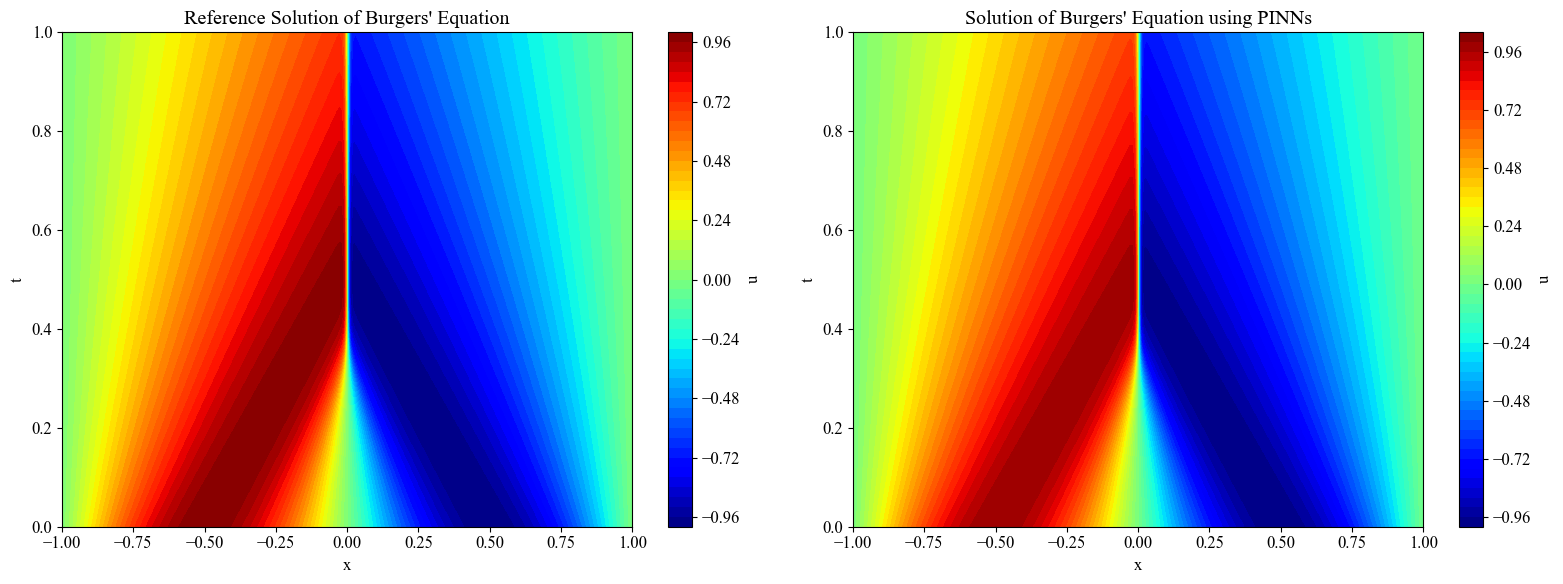

In [14]:
t = np.linspace(0, 1, 100)
x = np.linspace(-1, 1, 256)
xx,tt = np.meshgrid(x, t)
X = np.vstack((xx.ravel(), tt.ravel())).T

y_pred = model.predict(X)
y_pred_reshaped = y_pred.reshape(len(t), len(x))

plt.figure(figsize=(16, 6))

plt.subplot(121)
plt.contourf(xx, tt, exact_u, levels=50, cmap='jet')
plt.colorbar(label="u")
plt.xlabel('x')
plt.ylabel('t')
plt.title("Reference Solution of Burgers\' Equation")

plt.subplot(122)
plt.contourf(xx, tt, y_pred_reshaped, levels=50, cmap='jet')
plt.colorbar(label="u")
plt.xlabel('x')
plt.ylabel('t')
plt.title("Solution of Burgers\' Equation using PINNs")

plt.tight_layout()
plt.show()

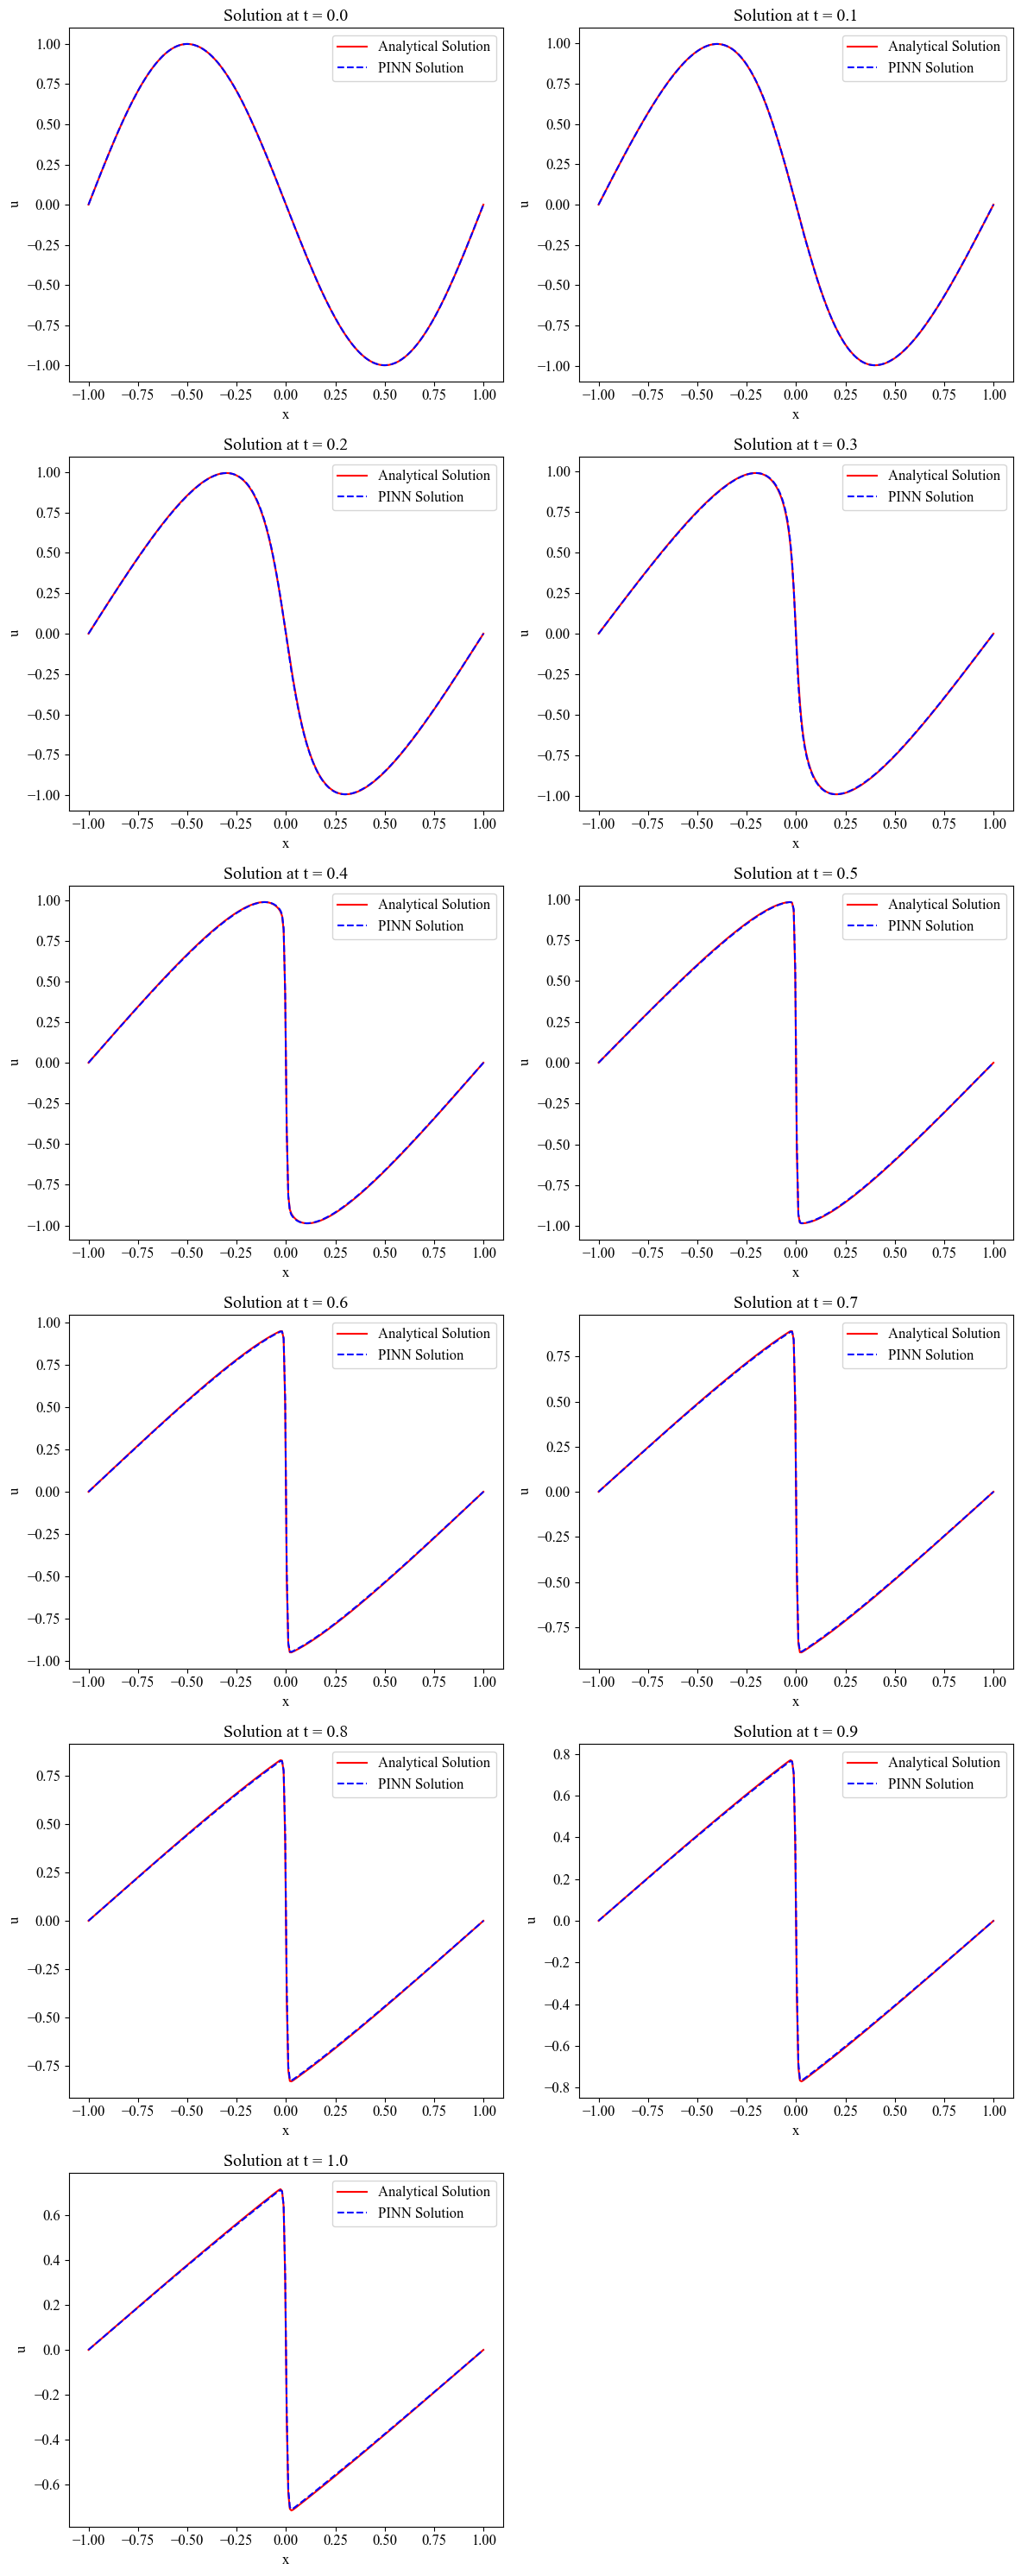

In [16]:
time_slices = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

num_plots = len(time_slices)
cols = 2
rows = (num_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 5*rows))
axes = axes.flatten()

for i, t_val in enumerate(time_slices):
    idx = np.argmin(np.abs(t - t_val))
    y_analytical = exact_u[idx, :]
    y_pinn = y_pred_reshaped[idx, :]

    ax = axes[i]
    ax.plot(x, y_analytical, 'r-', label="Analytical Solution")
    ax.plot(x, y_pinn, 'b--', label="PINN Solution")
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.set_title(f"Solution at t = {t_val}")
    ax.legend()

for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()